In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [2]:
models = torch.load("model/lag_activation.pt")

lagODE_logsigmoid, lagODE_softplus = models

lagODE_logsigmoid.eval()
lagODE_softplus.eval()

None

In [3]:
test_set = torch.load('data/SHM_test_set.pt')
train_set = torch.load('data/SHM_training_set.pt')[:300]

### Get test err

In [4]:
test_err = []
train_err = []
test_t_span = test_set[0, :, -1]
train_t_span = train_set[0, :, -1]

for model in models:
    test_traj = model.trajectory(test_set[:, 0, 0:2], test_t_span).transpose(0,1)
    test_loss = torch.nn.functional.mse_loss(test_traj, test_set[:, :, 0:2])
    
    train_traj = model.trajectory(train_set[:, 0, 0:2], train_t_span).transpose(0,1)
    train_loss = torch.nn.functional.mse_loss(train_traj, train_set[:, :, 0:2])
    
    test_err.append(test_loss)
    train_err.append(train_loss)

In [5]:
for i in range(2):
    print(train_err[i])
    print(test_err[i])

tensor(0.9981, grad_fn=<MseLossBackward>)
tensor(1.2574e+13, grad_fn=<MseLossBackward>)
tensor(8.8768e-06, grad_fn=<MseLossBackward>)
tensor(6.9725, grad_fn=<MseLossBackward>)


Epoch till converge: 108 5835
err: 1.14 7.44e-06

### Phase Portrait

In [6]:
from torchdyn.models import NeuralODE

from module import LNN
from nn import MLP, PSD

lagFunc_softplus = LNN(num_angle=0, lagrangianNet=MLP([2, 32, 33, 1], activation='softplus'))
lagODE_softplus = NeuralODE(lagFunc_softplus, sensitivity='adjoint', solver='rk4').to(device)

In [7]:
test_model = models[1]
# test_model = lagODE_softplus

In [8]:
with torch.no_grad():
    n_grid = 100
    x = torch.linspace(-5.5, 5.5, n_grid)
#     x = torch.linspace(-20., 20., n_grid)
    Q, dQ = torch.meshgrid(x, x)  # all (q, p)

    L, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)

    for i in range(n_grid):
        for j in range(n_grid):
            x = torch.cat([Q[i, j].reshape(1, 1), dQ[i, j].reshape(1, 1)], 1)
            L[i, j] = test_model.defunc.m.L(x)
            grad = test_model.defunc(0, x).detach().cpu()
            U[i, j], V[i, j] = grad[:, 0], grad[:, 1]

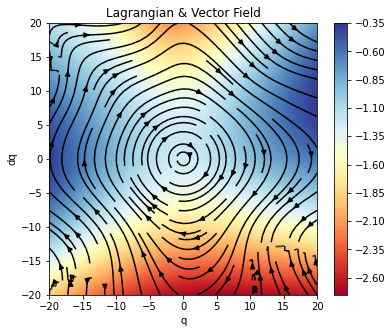

In [9]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
CS = ax.contourf(Q, dQ, L, 100, cmap='RdYlBu')
fig.colorbar(CS)

ax.streamplot(Q.T.numpy(), dQ.T.numpy(), U.T.numpy(), V.T.numpy(), color='black')

ax.set_xlim([Q.min(), Q.max()])
ax.set_ylim([dQ.min(), dQ.max()])
ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Lagrangian & Vector Field")
None

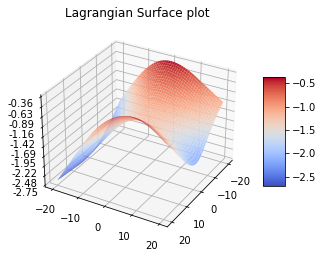

In [10]:
# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(Q.numpy(), dQ.numpy(), L.numpy(), cmap='coolwarm')

# Customize the z axis.
ax.set_zlim(L.min(), L.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
ax.view_init(30, 30)

ax.set_title("Lagrangian Surface plot")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

None

In [11]:
test_traj1 = test_model.trajectory(torch.tensor([[-6., 80.]]), torch.linspace(0, 1., 10)).detach()
test_traj2 = test_model.trajectory(torch.tensor([[1., 1.]]), torch.linspace(0, 1., 10)).detach()

In [12]:
test_traj1

tensor([[[-6.0000e+00,  8.0000e+01]],

        [[ 2.8425e+00,  9.1822e+01]],

        [[ 1.1821e+02,  3.1100e+03]],

        [[ 7.5499e+02,  8.3513e+03]],

        [[ 2.0536e+03,  1.5726e+04]],

        [[ 4.4325e+03,  2.7094e+04]],

        [[ 8.0746e+03,  3.8584e+04]],

        [[ 1.3043e+04,  5.0850e+04]],

        [[ 1.9395e+04,  6.3843e+04]],

        [[ 2.7251e+04,  7.7563e+04]]])

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Trajectories of random L')

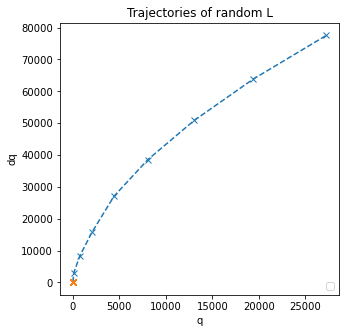

In [13]:
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

ax1.plot(test_traj1[:, 0, 0], test_traj1[:, 0, 1], 'x--')
ax1.plot(test_traj2[:, 0, 0], test_traj2[:, 0, 1], 'x--')

ax1.set_xlabel("q")
ax1.set_ylabel("dq")
ax1.legend(loc='lower right')
ax1.set_title("Trajectories of random L")

### Trajectory Test

In [14]:
from utils import SHM_1D_model

In [15]:
# Generate Trajectory from true model
t0 = 0
dt = 0.05
steps = 200
t1 = int(dt * steps)

q_p1, dq_dp1, _, ts1 = SHM_1D_model(x0=1.5, p0=1.5, t0=t0, t1=t1, steps=steps)
q_p2, dq_dp2, _, ts2 = SHM_1D_model(x0=4, p0=4, t0=t0, t1=t1, steps=steps)

# Generate Estimated Trajectory
t_span = torch.linspace(t0, t1, steps)

traj1_logsigmoid = models[0].trajectory(q_p1[[0], :], t_span).detach()  # (time, points, dim)
traj1_softplus = models[1].trajectory(q_p1[[0], :], t_span).detach()  # (time, points, dim)

traj2_logsigmoid = models[0].trajectory(q_p2[[0], :], t_span).detach()  # (time, points, dim)
traj2_softplus = models[1].trajectory(q_p2[[0], :], t_span).detach()  # (time, points, dim)

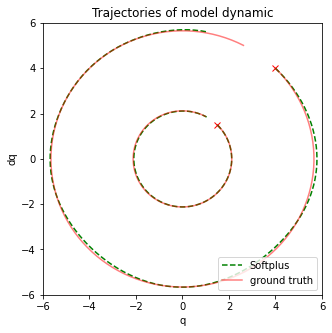

In [23]:
# Plot the trajectory generated from the model
# Phase Plot
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

length = 120
ax1.plot(q_p1[0, 0], q_p1[0, 1], marker='x', color="red")  # init pos
ax1.plot(q_p2[0, 0], q_p2[0, 1], marker='x', color="red")  # init pos

# ax1.plot(traj1_logsigmoid[:length, 0, 0], traj1_logsigmoid[:length, 0, 1], 'b--', label='logSigmoid')  # traj
ax1.plot(traj1_softplus[:length, 0, 0], traj1_softplus[:length, 0, 1], 'g--', label='Softplus')  # traj

ax1.plot(q_p1[:length, 0], q_p1[:length, 1], color='red', alpha=0.5, label='ground truth')  # traj

# ax1.plot(traj2_logsigmoid[:length, 0, 0], traj2_logsigmoid[:length, 0, 1], 'b--')  # traj
ax1.plot(traj2_softplus[:length, 0, 0], traj2_softplus[:length, 0, 1], 'g--')  # traj

ax1.plot(q_p2[:length, 0], q_p2[:length, 1], color='red', alpha=0.5)  # traj

ax1.set_xlim([-6., 6.])
ax1.set_ylim([-6., 6.])
ax1.set_xlabel("q")
ax1.set_ylabel("dq")
ax1.legend(loc='lower right')
ax1.set_title("Trajectories of model dynamic")

None

### Hamiltonian

In [30]:
test_model = models[1]
# test_model = lagODE_softplus

In [51]:
with torch.no_grad():
    n_grid = 100
    x = torch.linspace(-4.5, 4.5, n_grid)
#     x = torch.linspace(-20., 20., n_grid)
    Q, dQ = torch.meshgrid(x, x)  # all (q, p)

    # H is Hamiltonian
    # (U, V) are the symplectic gradient
    H, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)

    P = torch.zeros_like(dQ)

    for i in range(n_grid):
        for j in range(n_grid):
            # The current canonical coordinate
            x = torch.cat([Q[i, j].reshape(1, 1), dQ[i, j].reshape(1, 1)], 1)
            H[i, j], P[i, j] = test_model.defunc.m.H_p_legendre(x)
            grad = test_model.defunc(0, x)
            U[i, j], V[i, j] = grad[:, 0], grad[:, 1]

    P = P

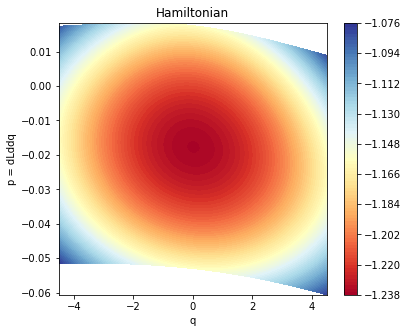

In [57]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
CS = ax.contourf(Q, -P, -H, 100, cmap='RdYlBu')
fig.colorbar(CS)

# ax.set_xlim([Q.min(), Q.max()])
# ax.set_ylim([P.min(), P.max()])
ax.set_xlabel("q")
ax.set_ylabel("p = dLddq")
ax.set_title("Hamiltonian")
None

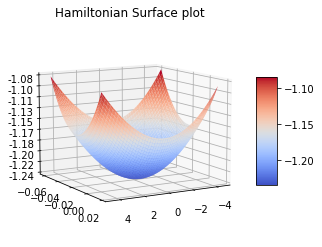

In [56]:
# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(Q.numpy(), -P.numpy(), -H.numpy(), cmap='coolwarm')

# Customize the z axis.
# ax.set_zlim(H.min(), H.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
ax.view_init(10, 60)

ax.set_title("Hamiltonian Surface plot")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

None

In [36]:
P

tensor([[ 0.0515,  0.0508,  0.0501,  ..., -0.0161, -0.0168, -0.0174],
        [ 0.0515,  0.0508,  0.0500,  ..., -0.0162, -0.0168, -0.0174],
        [ 0.0514,  0.0507,  0.0500,  ..., -0.0162, -0.0168, -0.0174],
        ...,
        [ 0.0602,  0.0595,  0.0588,  ..., -0.0080, -0.0086, -0.0093],
        [ 0.0604,  0.0597,  0.0590,  ..., -0.0078, -0.0084, -0.0091],
        [ 0.0606,  0.0599,  0.0592,  ..., -0.0075, -0.0082, -0.0089]])

### s-t v-t

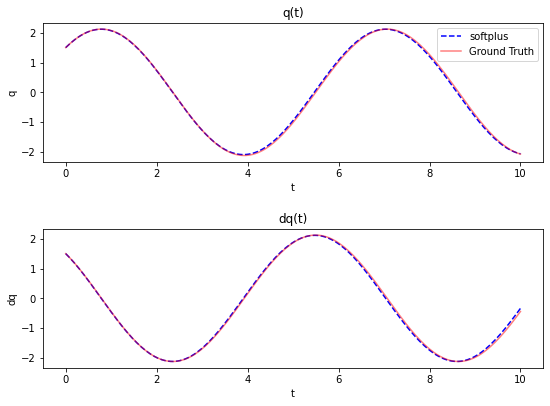

In [34]:
# Plot q(t) and p(t) graph
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)

ax1.plot(t_span, traj1_softplus[:, 0, 0], '--', color='blue', label='softplus')  # traj
ax1.plot(t_span, q_p1[:, 0], color='red', alpha=0.5, label='Ground Truth')  # traj

ax1.set_xlabel("t")
ax1.set_ylabel("q")
ax1.set_title("q(t)")
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(t_span, traj1_softplus[:, 0, 1], '--', color='blue')  # traj
ax2.plot(t_span, q_p1[:, 1], color='red', alpha=0.5)  # traj

ax2.set_xlabel("t")
ax2.set_ylabel("dq")
ax2.set_title("dq(t)")

fig.tight_layout(pad=2.0)
None

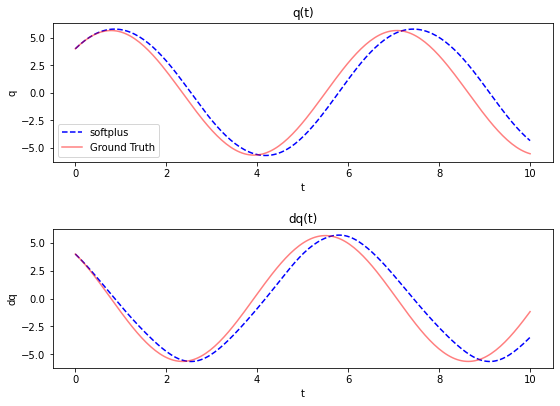

In [35]:
# Plot q(t) and p(t) graph
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)

ax1.plot(t_span, traj2_softplus[:, 0, 0], '--', color='blue', label='softplus')  # traj
ax1.plot(t_span, q_p2[:, 0], color='red', alpha=0.5, label='Ground Truth')  # traj

ax1.set_xlabel("t")
ax1.set_ylabel("q")
ax1.set_title("q(t)")
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(t_span, traj2_softplus[:, 0, 1], '--', color='blue')  # traj
ax2.plot(t_span, q_p2[:, 1], color='red', alpha=0.5)  # traj

ax2.set_xlabel("t")
ax2.set_ylabel("dq")
ax2.set_title("dq(t)")

fig.tight_layout(pad=2.0)
None